In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy

import pandas as pd
import scorecardpy as sc

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [2]:
x_train = pd.read_csv("X_train.csv")
x_valid = pd.read_csv("X_valid.csv")

y_train = pd.read_csv("y_train.csv")
y_valid = pd.read_csv("y_valid.csv")

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((54315, 59), (9586, 59), (54315, 1), (9586, 1))

In [3]:
def calcular_pesos(modelo):
    coef_model = pd.DataFrame(modelo.tvalues, columns=['t_value'])
    coef_model['t_value2'] = np.power(coef_model['t_value'],2)
    coef_model['total'] = sum(coef_model['t_value2'])
    coef_model['part'] = coef_model['t_value2'] / coef_model['total']
    coef_model['pesos'] = coef_model['part'] * 100
    return coef_model['pesos'].sort_values(ascending=True)

### >> Modleo mayor p-value

In [4]:
cols_aporte = [
 'Empleado',
 'Tiempo_empleo',
 'Saldo_cuenta',
 'Valor_prestamo',
 'Cuentas_otros',
 'Autocontrol',
 'Impulsividad',
 'Confianza' 
]

In [5]:
x_train['target'] = y_train.values
matriz_corr = x_train[cols_aporte + ['target']].corr(method='pearson')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,0.48037,-0.00128,-0.00633,-0.00115,0.00754,-0.00448,0.00228,-0.00068
Tiempo_empleo,0.48037,1.00000,0.00696,-0.00080,-0.00228,0.00410,-0.00682,0.00556,0.00129
Saldo_cuenta,-0.00128,0.00696,1.00000,0.00120,0.00043,-0.00272,0.00377,-0.00196,-0.00716
Valor_prestamo,-0.00633,-0.00080,0.00120,1.00000,-0.00041,0.00983,-0.00334,-0.00069,-0.00088
Cuentas_otros,-0.00115,-0.00228,0.00043,-0.00041,1.00000,-0.00159,0.00314,-0.00146,0.00477
Autocontrol,0.00754,0.00410,-0.00272,0.00983,-0.00159,1.00000,0.00585,0.00627,-0.00449
Impulsividad,-0.00448,-0.00682,0.00377,-0.00334,0.00314,0.00585,1.00000,-0.00233,-0.00322
Confianza,0.00228,0.00556,-0.00196,-0.00069,-0.00146,0.00627,-0.00233,1.00000,-0.00062
target,-0.00068,0.00129,-0.00716,-0.00088,0.00477,-0.00449,-0.00322,-0.00062,1.00000


In [6]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00716
Cuentas_otros,0.00477
Autocontrol,0.00449
Impulsividad,0.00322
Tiempo_empleo,0.00129
Valor_prestamo,0.00088
Empleado,0.00068
Confianza,0.00062


In [7]:
matriz_corr = x_train[cols_aporte + ['target']].corr(method='spearman')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,0.61396,0.00270,-0.00463,0.00038,0.00647,-0.00503,0.00187,-0.00068
Tiempo_empleo,0.61396,1.00000,0.00137,-0.00128,-0.00269,0.00448,-0.00591,0.00414,0.00045
Saldo_cuenta,0.00270,0.00137,1.00000,0.00463,0.00004,-0.00199,0.00101,-0.00535,-0.00680
Valor_prestamo,-0.00463,-0.00128,0.00463,1.00000,-0.00142,0.00946,-0.00336,-0.00009,-0.00345
Cuentas_otros,0.00038,-0.00269,0.00004,-0.00142,1.00000,-0.00163,0.00415,-0.00101,0.00393
Autocontrol,0.00647,0.00448,-0.00199,0.00946,-0.00163,1.00000,0.00551,0.00627,-0.00370
Impulsividad,-0.00503,-0.00591,0.00101,-0.00336,0.00415,0.00551,1.00000,-0.00156,-0.00377
Confianza,0.00187,0.00414,-0.00535,-0.00009,-0.00101,0.00627,-0.00156,1.00000,-0.00111
target,-0.00068,0.00045,-0.00680,-0.00345,0.00393,-0.00370,-0.00377,-0.00111,1.00000


In [8]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00680
Cuentas_otros,0.00393
Impulsividad,0.00377
Autocontrol,0.00370
Valor_prestamo,0.00345
Confianza,0.00111
Empleado,0.00068
Tiempo_empleo,0.00045


In [9]:
del x_train['target']

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

kfold_off_on = StratifiedKFold(
    n_splits=3, 
    shuffle=True,
    random_state=SEED
)

param_grid_arbol = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],             # ‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}
    'min_samples_split': [5, 10, 15],
    'max_depth': [3, 4, 5],
    'max_features': [0.8, 0.9, 1],
    'random_state': [SEED],
    'class_weight': ['balanced', None]
}
model_arbol = DecisionTreeClassifier(random_state=SEED)

grid_arbol = RandomizedSearchCV(
    model_arbol, 
    {k: [v] if not isinstance(v, list) else v for k, v in param_grid_arbol.items()}, 
    cv=kfold_off_on, 
    n_jobs=4, 
    scoring='roc_auc', 
    verbose=1,
    n_iter=120
)


logit_model_2 = sm.Logit(y_train , x_train[cols_aporte])
result_2 = logit_model_2.fit()

Optimization terminated successfully.
         Current function value: 0.409889
         Iterations 6


In [17]:
%%time
grid_arbol.fit(
    x_train[cols_aporte],
    y_train,
)

best_params_arbol = grid_arbol.best_params_
score_arbol = grid_arbol.best_score_
result_2 = grid_arbol.best_estimator_

print("score: ", score_arbol)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 324 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 353 out of 360 | elapsed:   12.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   12.7s finished


score:  0.5028252941007597
Wall time: 13 s


In [22]:
import numpy as np
#prediciendo en base al modelo 
y_pred_prob_2_train = result_2.predict_proba(x_train[cols_aporte])[:,1]
y_pred_class_2_train = np.where(y_pred_prob_2_train < 0.5, 0 , 1)

y_pred_prob_2_valid = result_2.predict_proba(x_valid[cols_aporte])[:,1]
y_pred_class_2_valid = np.where(y_pred_prob_2_valid < 0.5, 0 , 1)

In [23]:
pd.Series(y_pred_class_2_train).value_counts()

0    54302
1       13
dtype: int64

In [24]:
pd.Series(y_pred_class_2_valid).value_counts()

0    9584
1       2
dtype: int64

<AxesSubplot:>

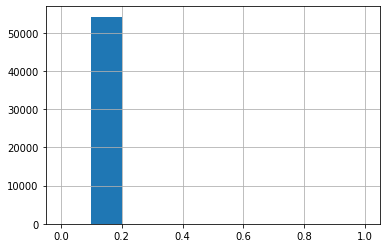

In [26]:
pd.Series(y_pred_prob_2_train).hist()

<AxesSubplot:>

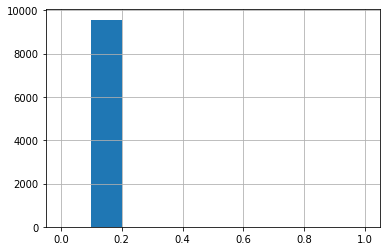

In [27]:
pd.Series(y_pred_prob_2_valid).hist()

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

print("/"*25, 'TRAIN')
auc = roc_auc_score(y_train, y_pred_prob_2_train)
print("AUC: %1.3f" % auc)
print("GINI: %1.3f" % (2*auc-1))

print("/"*25, 'VALIDATION')
auc_2 = roc_auc_score(y_valid, y_pred_prob_2_valid)
print("AUC: %1.3f" % auc_2)
print("GINI: %1.3f" % (2*auc_2-1))

///////////////////////// TRAIN
AUC: 0.506
GINI: 0.011
///////////////////////// VALIDATION
AUC: 0.501
GINI: 0.002


In [29]:
print("/"*25, 'TRAIN')
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_2_train))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_2_train))

print("/"*25, 'VALIDATION')
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_2_valid))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_2_valid))

///////////////////////// TRAIN
RECALL     : 0.00104343
EFECTIVIDAD: 0.61538462
F1 SCORE   : 0.00208333
///////////////////////// VALIDATION
RECALL     : 0.00073910
EFECTIVIDAD: 0.50000000
F1 SCORE   : 0.00147601


#### >>> RECALL

In [30]:
from scipy.optimize import differential_evolution


optimization_rec = differential_evolution(
    lambda c: -1*recall_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_rec

     fun: -1.0
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 5
 success: True
       x: array([0.02360338])

In [31]:
corte_rec = optimization_rec['x'][0]
corte_rec

0.023603376913245155

In [32]:
y_pred_class_train_2_rec = np.where(y_pred_prob_2_train < corte_rec, 0 , 1)
y_pred_class_valid_2_rc = np.where(y_pred_prob_2_valid < corte_rec, 0 , 1)

In [33]:
pd.Series(y_pred_class_train_2_rec).value_counts()

1    54287
0       28
dtype: int64

In [34]:
pd.Series(y_pred_class_valid_2_rc).value_counts()

1    9585
0       1
dtype: int64

In [35]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_rec))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_rec))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_rec))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_rc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_rc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_rc))

///////////////////////// TRAIN
RECALL     : 1.00000000
EFECTIVIDAD: 0.14123087
F1 SCORE   : 0.24750621
///////////////////////// VALIDATION
RECALL     : 0.99926090
EFECTIVIDAD: 0.14105373
F1 SCORE   : 0.24721156


#### >>> EFECTIVIDAD

In [36]:
optimization_pre = differential_evolution(
    lambda c: -1*precision_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_pre

     fun: -1.0
 message: 'Optimization terminated successfully.'
    nfev: 47
     nit: 2
 success: True
       x: array([0.95154034])

#### >>> AUC

In [37]:
optimization_auc = differential_evolution(
    lambda c: -1*roc_auc_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_auc

     fun: -0.50114893122279
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.1890528])

In [38]:
corte_auc = optimization_auc['x'][0]
corte_auc

0.18905280011256897

In [39]:
y_pred_class_train_2_auc = np.where(y_pred_prob_2_train < corte_auc, 0 , 1)
y_pred_class_valid_2_auc = np.where(y_pred_prob_2_valid < corte_auc, 0 , 1)

In [41]:
pd.Series(y_pred_class_train_2_auc).value_counts()

0    54238
1       77
dtype: int64

In [42]:
pd.Series(y_pred_class_valid_2_auc).value_counts()

0    9572
1      14
dtype: int64

In [40]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_auc))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_auc))

///////////////////////// TRAIN
RECALL     : 0.00339116
EFECTIVIDAD: 0.33766234
F1 SCORE   : 0.00671488
///////////////////////// VALIDATION
RECALL     : 0.00295639
EFECTIVIDAD: 0.28571429
F1 SCORE   : 0.00585223
